In [1]:
import sys
sys.path.append("../../")  # path contains python_file.py

In [2]:
import iris
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import warnings

In [3]:
%load_ext autoreload
%autoreload 2

# Testing data ISIMIP

In [4]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def day(x):
    return x.day

def month(x):
    return x.month

def year(x):
    return x.year

day = np.vectorize(day)
month = np.vectorize(month)
year = np.vectorize(year)


def read_in_and_preprocess_isimip_testing_data_with_dates(variable, grid_point = [0,0]):
    
    obs = iris.load_cube("../testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm_hist = iris.load_cube("../testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    cm_future = iris.load_cube("../testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "obs": get_dates(obs),
        "cm_hist": get_dates(cm_hist),
        "cm_future": get_dates(cm_future)
    }
    
    obs = np.array(obs.data)
    cm_hist = np.array(cm_hist.data)
    cm_future = np.array(cm_future.data)

    
    obs = np.moveaxis(obs, -1, 0)
    cm_hist = np.moveaxis(cm_hist, -1, 0)
    cm_future = np.moveaxis(cm_future, -1, 0)

    obs = obs[:,  grid_point[0], grid_point[1]]
    cm_hist = cm_hist[:,  grid_point[0], grid_point[1]]
    cm_future = cm_future[:,  grid_point[0], grid_point[1]]
    
    return obs, cm_hist, cm_future, dates

def map_distribution_to_isimip_name(distribution):
    if distribution == scipy.stats.norm:
        return "normal"
    elif distribution == scipy.stats.beta:
        return "beta"
    elif distribution == scipy.stats.rice:
        return "rice"
    elif distribution == scipy.stats.weibull_min:
        return "weibull"
    elif distribution == scipy.stats.gamma:
        return "gamma"
    else:
        raise ValueError("Not recognized")

# Comparison ISIMIP and PACKAGE_NAME

In [5]:
from PACKAGE_NAME.debias import ISIMIP
import PACKAGE_NAME.debias.code_isimip.utility_functions as uf
from PACKAGE_NAME.debias.code_isimip.bias_adjustment import adjust_bias_one_month

# Check windows:

In [6]:
import PACKAGE_NAME.utils as utils
variable = "tas"
obs_hist, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable, grid_point = [1,1])
debiaser = ISIMIP.from_variable(variable=variable)

days_of_year_obs = utils.day_of_year(dates["obs"])
days_of_year_cm_hist = utils.day_of_year(dates["cm_hist"])
days_of_year_cm_future = utils.day_of_year(dates["cm_future"])

years_cm_future = utils.year(dates["cm_future"])

window_centers = debiaser.running_window._get_window_centers(np.max(days_of_year_cm_future))
window_centers_isimip = uf.window_centers_for_running_bias_adjustment(days_of_year_cm_future, debiaser.running_window_step_length)

assert window_centers.size == window_centers_isimip.size


/home/jakobwes/anaconda3/envs/ibias4/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [7]:
for day_of_year_center, day_of_year_center_isimip in zip(window_centers, window_centers_isimip):

    indices_obs_hist = debiaser.running_window.get_indices_vals_in_window(days_of_year_obs, day_of_year_center)
    indices_cm_hist = debiaser.running_window.get_indices_vals_in_window(days_of_year_cm_hist, day_of_year_center)
    indices_cm_future = debiaser.running_window.get_indices_vals_in_window(days_of_year_cm_future, day_of_year_center)
        
    indices_obs_hist_isimip = uf.window_indices_for_running_bias_adjustment(days_of_year_obs, day_of_year_center_isimip, debiaser.running_window_length)
    indices_cm_hist_isimip = uf.window_indices_for_running_bias_adjustment(days_of_year_cm_hist, day_of_year_center_isimip, debiaser.running_window_length)
    indices_cm_future_isimip = uf.window_indices_for_running_bias_adjustment(days_of_year_cm_future, day_of_year_center_isimip, debiaser.running_window_length)

    indices_bc_values = debiaser.running_window.get_indices_vals_to_adjust(days_of_year_cm_future, years_cm_future, day_of_year_center)
    indices_bc_values_isimip = uf.window_indices_for_running_bias_adjustment(days_of_year_cm_future, day_of_year_center_isimip, debiaser.running_window_step_length, years_cm_future)
    
    assert all(indices_obs_hist == indices_obs_hist_isimip)
    assert all(indices_cm_hist == indices_cm_hist_isimip)
    assert all(indices_cm_future == indices_cm_future_isimip)
    
    assert all(indices_bc_values == indices_bc_values_isimip)

# Consistency within window


In [8]:
def get_results_within_window(debiaser, obs_hist, cm_hist, cm_future, years_obs_hist, years_cm_hist, years_cm_future):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        result = debiaser._apply_on_window(obs_hist, cm_hist, cm_future, years_obs_hist, years_cm_hist, years_cm_future)

        isimip_result = adjust_bias_one_month(
            data = {'obs_hist': [obs_hist], 'sim_hist': [cm_hist], 'sim_fut': [cm_future]},
            years = {'obs_hist': years_obs_hist, 'sim_hist': years_cm_hist, 'sim_fut': years_cm_future},
            long_term_mean = {'obs_hist' : [obs_hist.mean()], 'sim_hist' : [cm_hist.mean()], 'sim_fut' : [cm_future.mean()]},
            lower_bound = [None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound],
            lower_threshold = [None if np.isinf(debiaser.lower_threshold) else debiaser.lower_threshold],
            upper_bound = [None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound],
            upper_threshold = [None if np.isinf(debiaser.upper_threshold) else debiaser.upper_threshold],
            unconditional_ccs_transfer=[not debiaser.trend_transfer_only_for_values_within_threshold],
            trendless_bound_frequency=[False],
            randomization_seed=None,
            detrend=[debiaser.detrending],
            rotation_matrices=[],
            n_quantiles=min(obs_hist.size, cm_hist.size, cm_future.size)-1,
            distribution=[map_distribution_to_isimip_name(debiaser.distribution)],
            trend_preservation=[debiaser.trend_preservation_method],
            adjust_p_values=[debiaser.event_likelihood_adjustment],
            invalid_value_warnings=True
        )[0]
        
    return result, isimip_result

def get_pct_exact_max_deviation_diff_within_window(debiaser, obs_hist, cm_hist, cm_future, years_obs_hist, years_cm_hist, years_cm_future):
    result, isimip_result = get_results_within_window(debiaser, obs_hist, cm_hist, cm_future, years_obs_hist, years_cm_hist, years_cm_future)
    
    pct_exact = np.sum(np.isclose(result, isimip_result))/result.size
    max_deviation = np.max(np.abs(result-isimip_result))
    diff = result-isimip_result
    
    return pct_exact, max_deviation, diff

    
def test_consistency_monthly_iteration(debiaser, obs_hist, cm_hist, cm_future, dates):
    
    years_obs_hist = year(dates["obs_hist"])
    years_cm_hist = year(dates["cm_hist"])
    years_cm_future = year(dates["cm_future"])

    pct_exact = np.zeros(12)
    max_deviations = np.zeros(12)
    diffs = []
    
    for chosen_month in range(1, 13):
        mask_obs_hist_month = month(dates["obs_hist"]) == chosen_month
        mask_cm_hist_month = month(dates["cm_hist"]) == chosen_month
        mask_cm_future_month = month(dates["cm_future"]) == chosen_month

        i = chosen_month-1
        pct_exact[i], max_deviations[i], diff = get_pct_exact_max_deviation_diff_within_window(
            debiaser, 
            obs_hist[mask_obs_hist_month], 
            cm_hist[mask_cm_hist_month], 
            cm_future[mask_cm_future_month], 
            years_obs_hist[mask_obs_hist_month], 
            years_cm_hist[mask_cm_hist_month], 
            years_cm_future[mask_cm_future_month]
        )
        diffs.append(diff)
        
    print("Average percent agreement across all months: %s"%pct_exact.mean())
    print("Month with least percent agreement: month %s with percent agreement of %s and max deviation of %s"%(pct_exact.argmin() +1, pct_exact.min(), max_deviations[pct_exact.argmin()]))
    print("Month with max devitation: month %s with max devitation %s and percent agreement of %s"%(max_deviations.argmax()+1, max_deviations.max(), pct_exact[max_deviations.argmax()]))
    print("Number of months with exact agreement (of 1.0): %s of %s"%((pct_exact == 1).sum(), 12))
    
    return pct_exact, max_deviations, diffs

def test_consistency_running_window_iteration(debiaser, obs_hist, cm_hist, cm_future, dates):
    
    years_obs_hist = year(dates["obs_hist"])
    years_cm_hist = year(dates["cm_hist"])
    years_cm_future = year(dates["cm_future"])
    
    days_of_year_cm_future = utils.day_of_year(dates["cm_future"])
    
    window_centers = debiaser._get_window_centers(np.max(days_of_year_cm_future))

    pct_exact = np.zeros_like(window_centers)
    max_deviations = np.zeros_like(window_centers)
    diffs = []
    
    for i, day_of_year_center in enumerate(window_centers):
        indices_obs_hist = debiaser._get_indices_around_window_center(days_of_year_obs_hist, day_of_year_center)
        indices_cm_hist = debiaser._get_indices_around_window_center(days_of_year_cm_hist, day_of_year_center)
        indices_cm_future = debiaser._get_indices_around_window_center(days_of_year_cm_future, day_of_year_center)

        pct_exact[i], max_deviations[i], diff = get_pct_exact_max_deviation_diff_within_window(
            debiaser, 
            obs_hist[indices_obs_hist], 
            cm_hist[indices_cm_hist], 
            cm_future[indices_cm_future], 
            years_obs_hist[indices_obs_hist], 
            years_cm_hist[indices_cm_hist], 
            years_cm_future[indices_cm_future]
        )        
        diffs.append(diff)
        
    print("Average percent agreement across all windows: %s"%pct_exact.mean())
    print("Window with least percent agreement: window center %s with percent agreement of %s and max deviation of %s"%(window_centers[pct_exact.argmin()], pct_exact.min(), max_deviations[pct_exact.argmin()]))
    print("Window with max devitation: window center %s with max devitation %s and percent agreement of %s"%(window_centers[max_deviations.max()], max_deviations.max(), pct_exact[max_deviations.argmax()]))
    print("Number of windows with exact agreement (of 1.0): %s of %s"%((pct_exact == 1).sum(), window_centers.size))

    return pct_exact, max_deviations, diffs

## Tas

In [17]:
variable = "tas"
obs_hist, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable, grid_point = [1,1])
debiaser = ISIMIP.from_variable(variable=variable)

In [18]:
pct_exact, max_deviations, diffs = test_consistency_monthly_iteration(debiaser, obs_hist, cm_hist, cm_future, dates)

Average percent agreement across all months: 0.9996719160104988
Month with least percent agreement: month 2 with percent agreement of 0.9960629921259843 and max deviation of 0.002960205078125
Month with max devitation: month 2 with max devitation 0.002960205078125 and percent agreement of 0.9960629921259843
Number of months with exact agreement (of 1.0): 11 of 12


In [19]:
pct_exact, max_deviations, diffs = test_consistency_running_window_iteration(debiaser, obs_hist, cm_hist, cm_future, dates)

Average percent agreement across all windows: 1.0
Window with least percent agreement: window center 1 with percent agreement of 1 and max deviation of 0
Window with max devitation: window center 1 with max devitation 0 and percent agreement of 1
Number of windows with exact agreement (of 1.0): 366 of 366


## Pr

In [12]:
variable = "pr"
obs_hist, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable, grid_point = [1,1])
debiaser = ISIMIP.from_variable(variable=variable)

In [13]:
pct_exact, max_deviations, diffs = test_consistency_monthly_iteration(debiaser, obs_hist, cm_hist, cm_future, dates)

Average percent agreement across all months: 0.9592293906810037
Month with least percent agreement: month 6 with percent agreement of 0.6666666666666666 and max deviation of 1.2575765140354633e-06
Month with max devitation: month 6 with max devitation 1.2575765140354633e-06 and percent agreement of 0.6666666666666666
Number of months with exact agreement (of 1.0): 9 of 12


In [14]:
pct_exact, max_deviations, diffs = test_consistency_running_window_iteration(debiaser, obs_hist, cm_hist, cm_future, dates)

Average percent agreement across all windows: 0.8060109289617486
Window with least percent agreement: window center 133 with percent agreement of 0 and max deviation of 0
Window with max devitation: window center 1 with max devitation 0 and percent agreement of 1
Number of windows with exact agreement (of 1.0): 295 of 366


## Psl

In [15]:
variable = "psl"
obs_hist, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("ps", grid_point = [1,1])
debiaser = ISIMIP.from_variable(variable=variable)

In [16]:
pct_exact, max_deviations, diffs = test_consistency_monthly_iteration(debiaser, obs_hist, cm_hist, cm_future, dates)

Average percent agreement across all months: 1.0
Month with least percent agreement: month 1 with percent agreement of 1.0 and max deviation of 0.0
Month with max devitation: month 2 with max devitation 0.2109375 and percent agreement of 1.0
Number of months with exact agreement (of 1.0): 12 of 12


In [17]:
pct_exact, max_deviations, diffs = test_consistency_running_window_iteration(debiaser, obs_hist, cm_hist, cm_future, dates)

Average percent agreement across all windows: 1.0
Window with least percent agreement: window center 1 with percent agreement of 1 and max deviation of 0
Window with max devitation: window center 1 with max devitation 0 and percent agreement of 1
Number of windows with exact agreement (of 1.0): 366 of 366


# Other / WIP

In [14]:
variable = "tasrange"
obs_hist, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable, grid_point = [1,1])
debiaser = ISIMIP.from_variable(variable=variable)

In [15]:
pct_exact, max_deviations, diffs = test_consistency_monthly_iteration(debiaser, obs_hist, cm_hist, cm_future, dates)

Average percent agreement across all months: 0.03425479073180369
Month with least percent agreement: month 4 with percent agreement of 0.0 and max deviation of 0.0020046234130859375
Month with max devitation: month 2 with max devitation 0.006083488464355469 and percent agreement of 0.03740157480314961
Number of months with exact agreement (of 1.0): 0 of 12


In [16]:
debiaser

ISIMIP(distribution=<scipy.stats._continuous_distns.rice_gen object at 0x7fbb8432a2b0>, trend_preservation_method='mixed', detrending=False, reasonable_physical_range=None, variable='tasrange', lower_bound=0.0, lower_threshold=0.01, upper_bound=inf, upper_threshold=inf, trend_removal_with_significance_test=True, trend_transfer_only_for_values_within_threshold=True, event_likelihood_adjustment=False, ecdf_method='linear_interpolation', iecdf_method='linear', mode_non_parametric_quantile_mapping='isimipv3.0', running_window_mode=True, running_window_length=31, running_window_step_length=1)

## Pr: month with biggest deviation

In [9]:
variable = "sfcWind"
obs_hist, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable, grid_point = [1,1])
debiaser = ISIMIP.from_variable(variable=variable)


In [10]:
years_obs_hist = year(dates["obs_hist"])
years_cm_hist = year(dates["cm_hist"])
years_cm_future = year(dates["cm_future"])

chosen_month = 6
mask_obs_hist_month = month(dates["obs_hist"]) == chosen_month
mask_cm_hist_month = month(dates["cm_hist"]) == chosen_month
mask_cm_future_month = month(dates["cm_future"]) == chosen_month

result, result_isimip = get_results_within_window(
    debiaser, 
    obs_hist[mask_obs_hist_month], 
    cm_hist[mask_cm_hist_month], 
    cm_future[mask_cm_future_month], 
    years_obs_hist[mask_obs_hist_month], 
    years_cm_hist[mask_cm_hist_month], 
    years_cm_future[mask_cm_future_month]
)

result, isimip_result = get_results_within_window(debiaser, obs_hist, cm_hist, cm_future, years_obs_hist, years_cm_hist, years_cm_future)


float32
x_target
float32
x_target_fit
float32
float32
x_target
float32
x_target_fit
float32


In [15]:
result.dtype

dtype('float32')

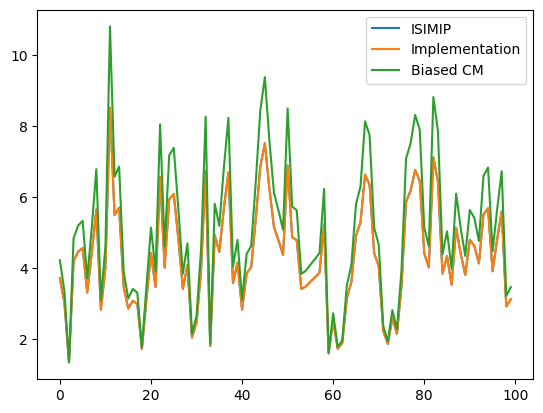

In [12]:
time = np.arange(isimip_result.size)[0:100]
plt.plot(time, isimip_result[0:100], label = "ISIMIP")
plt.plot(time, result[0:100], label = "Implementation")
plt.plot(time, cm_future[0:100], label = "Biased CM")
plt.legend()
plt.show()

In [21]:
zeros = np.where(result == 0)[0]
zeros_isimip = np.where(isimip_result==0)[0]

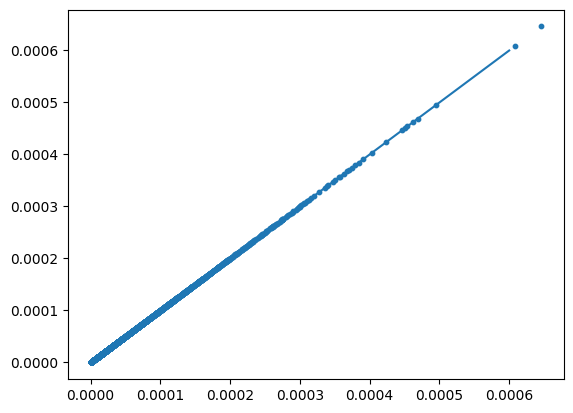

In [22]:
plt.scatter(result, isimip_result, s = 10)
plt.plot([0, 0.0006], [0, 0.0006])
plt.show()

In [ ]:
#def map_arguments_to_isimip_command_line_ones(debiaser):

def map_distribution_to_name(distribution):
    if distribution == scipy.stats.norm:
        return "normal"
    elif distribution == scipy.stats.gamma:
        return "gamma"
    else:
        raise ValueError("Unknown distribution")

def map_to_none_if_inf_else_value(value):
    if np.isinf(value):
        return None
    else:
        return value

def run_isimip_from_debiaser(debiaser, data_path = "isimip3basd-master/data/", data_path_debiased_models = "isimip3basd-master/data/debiased_models/"):
    arguments = {
        "n-processes": 5,
        "randomization-seed": 0
        "variable": debiaser.variable,
        "distribution": map_distribution_to_name(debiaser.distribution),
        "trend-preservation": debiaser.trend_preservation_method,
        "detrend": int(debiaser.detrending),
        "halfwin-upper-bound-climatology": 0,
        "lower-bound": map_to_none_if_inf_else_value(debiaser.lower_bound),
        "lower-threshold": map_to_none_if_inf_else_value(debiaser.lower_threshold),
        "upper-bound": map_to_none_if_inf_else_value(debiaser.upper_bound),
        "upper-threshold": map_to_none_if_inf_else_value(debiaser.upper_threshold),
        "unconditional-ccs-transfer": 1-int(debiaser.trend_transfer_only_for_values_within_threshold),
        "adjust-p-values" : int(debiaser.event_likelihood_adjustment),
        "halfwin-upper-bound-climatology": 0,
        "max-change-factor": 10000.,
        "max-adjustment-factor": 10000.,
        "step-size": debiaser.running_window_step_length if debiaser.running_window_mode else 0,
        "o": data_path+debiaser.variable+"_obs-hist_coarse_1979-2014.nc",
        "s": data_path+debiaser.variable+"_sim-hist_coarse_1979-2014.nc",
        "f": data_path+debiaser.variable+"_sim-fut_coarse_2065-2100.nc",
        "b": data_path_debiased_models+debiaser.variable+"_sim-fut-basd_coarse_2065-2100.nc",
        "n-quantiles": 15000
        
    }
    
    call = """python -u isimip3basd-master/code/bias_adjustment.py \
                --n-processes {n-processes} \
                --randomization-seed {randomization-seed} \
                --variable {variable} \
                --distribution {distribution} \
                --trend-preservation {trend-preservation} \
                --detrend {detrend} \
                --halfwin-upper-bound-climatology {halfwin-upper-bound-climatology} \
                --lower-bound {lower-bound} \
                --lower-threshold":
                --upper-bound": 
                "--upper-threshold": 
                unconditional-ccs-transfer":,
                "adjust-p-values" : ,
                "halfwin-upper-bound-climatology": 0,
                "max-change-factor": 10000.,
                "max-adjustment-factor": 10000.,
                -o {o} \
                -s {s} \
                -f {f} \
                -b {b} \
                --n-quantiles {n-quantiles} #\
                #--max-change-factor 10000. \
                #--max-adjustment-factor 10000.
                #--adjust-p-values 1
                #--if-all-invalid-use \
                #--trendless-bound-frequency \
                #--lower-bound , 0.\
                #--lower-threshold , 0.1 \
                #--upper-bound , \
                #--upper-threshold , \
                #--unconditional-ccs-transfer\
                #--step-size 1 \

    
    """

